# Requisição das imagens via satélite

<img src="https://www.intelligencepartner.com/wp-content/uploads/2016/10/logo_lockup_maps_apis_color-copy.png" alt="Testando, que legal!" width="50%">

O processo tecnico de nosso projeto requer que o usuario digite seu endereço para que possamos localizar seu telhado e realizar os calculos necessarios para que possamos fornecer uma estimativa de valor e performance da instalação de paineis solares. Tudo isso começa com um simples endereço, com esse endereço usamos a biblioteca `geopy` que atraves do `geocoders` se conecta ao serviço de geocodificação da OpenStreetMap, o Nominatim, e dessa forma converte o endereço em coordenadas. O beneficio de usar a classe `geocoder` do `geop` é que podemos facilmente converter endereços em coordenadas geográficas e vice-versa, sem precisar lidar diretamente com as APIs dos serviços de geocodificação.

O codigo abaixo é um exemplo funcional desse inicio do processo, ao roda-lo sera requisitado um endereço, ao digita-lo em poucos segundos esse endereço vira uma coordenada que é enviada ao Google Maps API que usando a função `retrieve_satellite_image` retorna uma imagem 1:1 de escala 20 (5) do endereço fornecido.

Digite seu endereço como o exemplo a seguir: Avenida Cais do Apolo, 77, Recife, Pernambuco, Brazil
Digite o endereço: 1600 Amphitheatre Parkway, Mountain View, California, USA
Latitude: 37.42248575
Longitude: -122.08558456613565


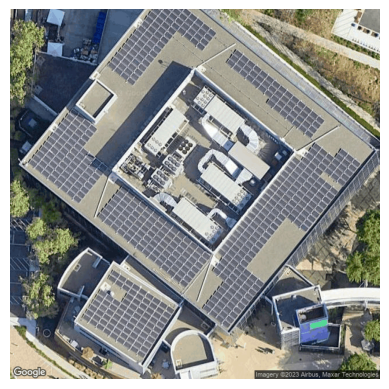

In [ ]:
from geopy.geocoders import Nominatim
import requests
import io
import matplotlib.pyplot as plt
from PIL import Image

def convert_address_to_coordinates(address):
    geolocator = Nominatim(user_agent="geo_app")
    location = geolocator.geocode(address)

    if location is None:
        return None

    coordinates = (location.latitude, location.longitude)
    return coordinates

def retrieve_satellite_image(latitude, longitude, zoom=20, size="1440x1080"):
    # Google Static Maps API base URL
    base_url = "https://maps.googleapis.com/maps/api/staticmap"

    #parametros para o request da API, tamanho (resolução) da imagem limitada pela versão basica da api
    params = {
        "center": f"{latitude},{longitude}",
        "zoom": zoom,
        "size": size,
        "maptype": "satellite",
        "key": "GOOGLE_MAPS_API_KEY_HERE" #Cuidado com minha chave! kkkk
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  #verifica erros no request

        #salva a imagem em um arquivo
        with open("satellite_image.png", "wb") as file:
            file.write(response.content)

        #carrega a imagem em memória
        image = Image.open(io.BytesIO(response.content))

        #exibe a imagem (para teste, no final so precisamos baixar msm)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    except requests.exceptions.RequestException as e:
        print(f"Ocorreu um erro: {e}")

#solicitar o endereço do usuário (teste)
print("Digite seu endereço como o exemplo a seguir: Avenida Cais do Apolo, 77, Recife, Pernambuco, Brazil")
address = input("Digite o endereço: ")

#converter endereço para coordenadas
coordinates = convert_address_to_coordinates(address)

if coordinates is not None:
    print(f"Latitude: {coordinates[0]}")
    print(f"Longitude: {coordinates[1]}")

    #pega a imagem de satélite
    retrieve_satellite_image(coordinates[0], coordinates[1], zoom=20)
else:
    print("Endereço inválido ou coordenadas não encontradas.")

# Criação da base de treino e teste do modelo

Para desenvolvimento do nosso modelo foi necessario criar um banco com diversas imagens via satelite da cidade do Recife para que possamos fazer o processo manual de labeling cada imagem, marcando os telhados e os painies solares (se presentes) para criamos uma base em um arquivo COCO (Common Objects in Context) que é um formato de arquivo usado para anotar e armazenar dados de treinamento em uma base de modelo de visão computacional. O formato COCO é amplamente utilizado para conjuntos de dados de detecção e segmentação de objetos, onde cada objeto é rotulado com uma caixa delimitadora e uma categoria. O arquivo COCO contém informações sobre as imagens de treinamento, incluindo os caminhos para os arquivos de imagem e os rótulos para cada objeto. Usamos o software Label Studio para em grupo fazer a marcação dessas imagens, adotamos o formato COCO porque ele é suportado por várias bibliotecas de visão computacional, como o TensorFlow Object Detection API e o Detectron2 que é o _framework_ que terminamos usando.

Para treinar esse modelo nos começamos com a ideia de pegar 200 imagens no banco ArcGIS da cidade do Recife, onde as imagens tem uma boa resolução, mas a comunicação com a API do servidor ArcGIS da cidade do Recife estava bastante complicado e erratica, muitas vezes parando de funionar, supomos que deve ser por causa da quantidade de requests que o nosso script estava fazendo. Por isso desistimos de usar o bando ArcGIS e passamos a usar 100% o Google Maps API, até porque a nossa solução final ja seria usando ele (devido a facil escalabilidade) então treinar o modelo no tipo de imagem que ele vai usar facilita nossos resultados.

Então para pegar todas essas imagens para o processo de labeling desenvolvemos um  script em python que dado as cordenadas das quatro pontas limites da cidade do Recife o script aleatoriamente escolhe uma coordenada dentro desee poligono e essa coordenada é enviada ao Google Maps API que retorna a iamgem dessa coordenada aleatoria, esse processo se repete X vezes e ao fim todas as imagens são colocadas em um arquivo ZIP. Ao rodar script com o X para 200 retornamso com um ZIP com 200 imagens, mas o que percebemos é que muitas dessas imagens eram de areas sem construções, matas, rios, mar ou até areas sem imagem (onde a API retorna uma imagem vazia com um erro). Então rodamos esse script com X = 1000, com essas 100 imagens fomos apagando todas que não eram aceitaveis para o treinamento, sobrando algo entorno de 300 imagens, dessas 300 pegamos 202 para treinar o modelo e separamos 67 para testa-lo.


In [ ]:
import os
import requests
import random
from PIL import Image
from io import BytesIO
import zipfile

# Google Maps API URL
GOOGLE_MAPS_API_URL = 'https://maps.googleapis.com/maps/api/staticmap'

API_KEY = ''

#limites do Recife em lagitutde e longitude
lat_min, lat_max = -8.2, -7.8
lon_min, lon_max = -35.05, -34.8

#cria zip
with zipfile.ZipFile('recife_images.zip', 'w') as zipf:

    #para cada imagem de 1 a 100
    for i in range(1, 101): #qnts de images

        #cria uma coordenada aleatoria dentro dos limites do recife
        lat = random.uniform(lat_min, lat_max)
        lon = random.uniform(lon_min, lon_max)

        #parametros da API
        params = {
            'center': f'{lat},{lon}',
            'zoom': '20',
            'size': '640x640',  #  '2048x2048' se tivessemos a api melhor :(
            'maptype': 'satellite',
            'key': API_KEY
        }

        #request
        response = requests.get(GOOGLE_MAPS_API_URL, params=params)


        img = Image.open(BytesIO(response.content))

        #salva os dados da imagem em objeto BytesIO
        img_byte_arr = BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()

        #dados no zip
        zipf.writestr(f'{i}.png', img_byte_arr)

        #print do progresso
        print(f'Saved image {i}')


Saved image 1
Saved image 2
Saved image 3
Saved image 4
Saved image 5
Saved image 6
Saved image 7
Saved image 8
Saved image 9
Saved image 10
Saved image 11
Saved image 12
Saved image 13
Saved image 14
Saved image 15
Saved image 16
Saved image 17
Saved image 18
Saved image 19
Saved image 20
Saved image 21
Saved image 22
Saved image 23
Saved image 24
Saved image 25
Saved image 26
Saved image 27
Saved image 28
Saved image 29
Saved image 30
Saved image 31
Saved image 32
Saved image 33
Saved image 34
Saved image 35
Saved image 36
Saved image 37
Saved image 38
Saved image 39
Saved image 40
Saved image 41
Saved image 42
Saved image 43
Saved image 44
Saved image 45
Saved image 46
Saved image 47
Saved image 48
Saved image 49
Saved image 50
Saved image 51
Saved image 52
Saved image 53
Saved image 54
Saved image 55
Saved image 56
Saved image 57
Saved image 58
Saved image 59
Saved image 60
Saved image 61
Saved image 62
Saved image 63
Saved image 64
Saved image 65
Saved image 66
Saved image 67
Save